In [211]:
!pip install indic-nlp-library

In [219]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from indicnlp.tokenize import indic_tokenize
import re
import os
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [220]:
import pandas as pd
all_data=pd.read_csv('/kaggle/input/multilingual-spam-data/data-en-hi-de-fr.csv',usecols=['labels','text','text_hi'])
all_data.head()

,labels,text,text_hi
0,ham,"Go until jurong point, crazy.. Available only ...","Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान वि..."
1,ham,Ok lar... Joking wif u oni...,ओके लामर.... if if uue पर.
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प...
3,ham,U dun say so early hor... U c already then say...,Uden इतना जल्दी कहते हैं... तो पहले से ही यूसी...
4,ham,"Nah I don't think he goes to usf, he lives aro...","नहीं, मुझे नहीं लगता कि वह हमारे लिए चला जाता ..."


In [221]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   labels   5572 non-null   object
 1   text     5572 non-null   object
 2   text_hi  5572 non-null   object
dtypes: object(3)
memory usage: 130.7+ KB


In [222]:
all_data.shape

(5572, 3)

In [223]:
all_data.labels.value_counts()

labels
ham     4825
spam     747
Name: count, dtype: int64

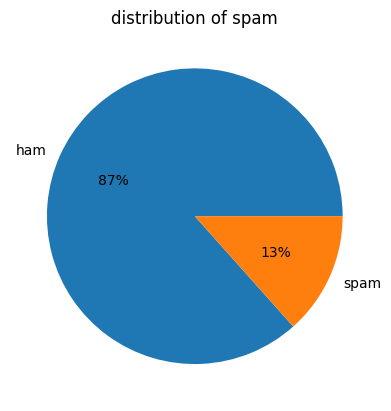

In [224]:
plt.title("distribution of spam")
plt.pie(all_data["labels"].value_counts().values,labels = all_data["labels"].value_counts().index,autopct="%.0f%%")
plt.show()

**Observation**

The data is imbalanced

To analyze patterns in the dataset preprocessing of the texts needs to be done

In [225]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [226]:
def preprocess_text_en(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'[0-9]','',text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word)>1]
    text = ' '.join(tokens)
    return text

In [227]:
# from langid.langid import LanguageIdentifier, model
def preprocess_text_hi(text):
#     identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    hindi_text = re.sub(r'[^ऀ-ॿ\s]', '', text)
    hindi_text = re.sub(r'[0-9]','',hindi_text)
    hindi_text = re.sub(r'[^\w\s\u0900-\u097F]', '', hindi_text)
    tokens = indic_tokenize.trivial_tokenize(hindi_text)
    tokens = [word for word in tokens if len(word)>1]
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if len(word) > 1]
    cleaned_text = ' '.join(tokens)        
    return cleaned_text.strip()

In [228]:
all_data.head(10)["text"]

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: text, dtype: object

In [229]:
all_data["text"]=all_data["text"].apply(preprocess_text_en)
all_data["text_hi"]=all_data["text_hi"].apply(preprocess_text_hi)

In [230]:
all_data.head(10)["text"]

0    go jurong point crazy available bugis great wo...
1                                ok lar joking wif oni
2    free entry wkly comp win fa cup final tkts st ...
3                        dun say early hor already say
4             nah dont think go usf life around though
5    freemsg hey darling week word back id like fun...
6        even brother like speak treat like aid patent
7    per request melle melle oru minnaminunginte nu...
8    winner valued network customer selected receiv...
9    mobile month entitled update latest colour mob...
Name: text, dtype: object

In [231]:
all_data.head(10)["text_hi"]

0    बिंदु तक जाओ पागल केवल महान विश्व में उपलब्ध ह...
1                                          ओके लामर पर
2    मई को प्राप्त करने के लिए मुफ्त प्रविष्टि में ...
3      इतना जल्दी कहते हैं तो पहले से ही यूसी कहते हैं
4    नहीं मुझे नहीं लगता कि वह हमारे लिए चला जाता ह...
5    अरे वहाँ प्रिय यह सप्ताह है और कोई शब्द वापस क...
6    मेरा भाई भी मेरे साथ बातें करना नहीं चाहता वे ...
7    जैसा कि प्रति आपकी निवेदन ओएगंखनन्ख सेट कर दिय...
8    एक मूल्यवान नेटवर्क ग्राहक के रूप में आप ९०० प...
9    क्या आपके महीने या उससे अधिक थे अमरीकी आर का श...
Name: text_hi, dtype: object

In [232]:
all_data.isna().sum()

labels     0
text       0
text_hi    0
dtype: int64

In [233]:
all_data.drop_duplicates(inplace=True)

In [234]:
lengths = []
lengths_hi = []
for i in all_data["text"].values:
    lengths.append(len(word_tokenize(i)))
for i in all_data["text_hi"].values:
    lengths_hi.append(len(indic_tokenize.trivial_tokenize(i)))
all_data["len_eng"] = lengths
all_data["len_hi"] = lengths_hi
all_data.head()

,labels,text,text_hi,len_eng,len_hi
0,ham,go jurong point crazy available bugis great wo...,बिंदु तक जाओ पागल केवल महान विश्व में उपलब्ध ह...,14,14
1,ham,ok lar joking wif oni,ओके लामर पर,5,3
2,spam,free entry wkly comp win fa cup final tkts st ...,मई को प्राप्त करने के लिए मुफ्त प्रविष्टि में ...,20,24
3,ham,dun say early hor already say,इतना जल्दी कहते हैं तो पहले से ही यूसी कहते हैं,6,11
4,ham,nah dont think go usf life around though,नहीं मुझे नहीं लगता कि वह हमारे लिए चला जाता ह...,8,18


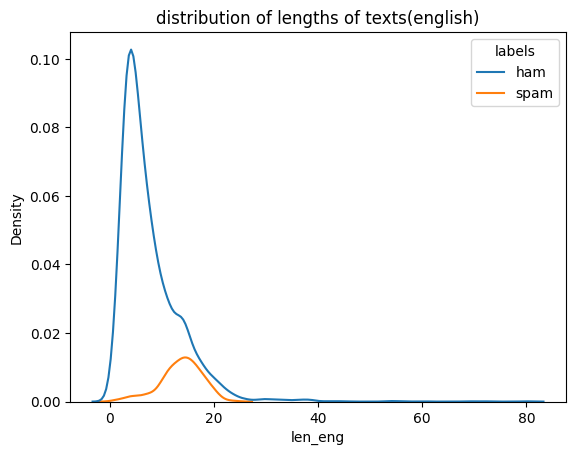

In [235]:
plt.title("distribution of lengths of texts(english)")
sns.kdeplot(data=all_data,x="len_eng",hue="labels")
plt.show()

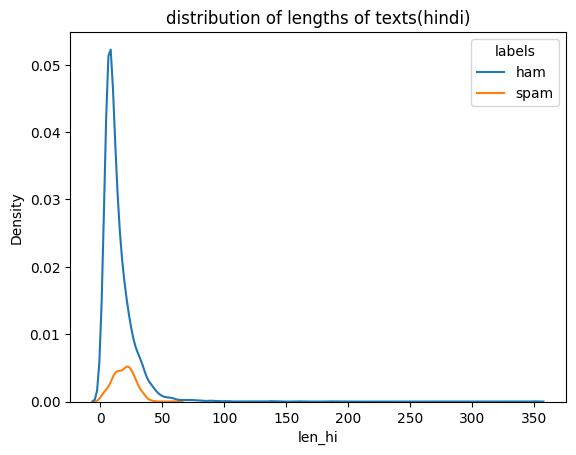

In [236]:
plt.title("distribution of lengths of texts(hindi)")
sns.kdeplot(data=all_data,x="len_hi",hue="labels")
plt.show()

In [237]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_data[all_data["labels"]=="spam"]["text"])  
vectorizer.get_feature_names_out()

array(['ab', 'aberdeen', 'abroad', ..., 'zf', 'zoe', 'zouk'], dtype=object)

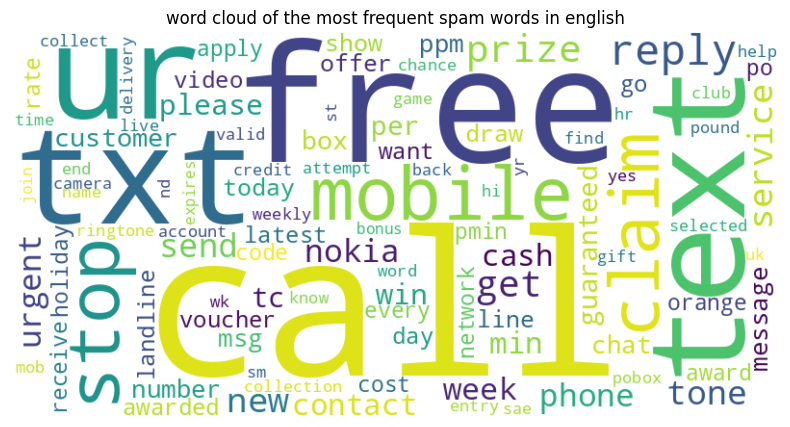

In [238]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

spam_texts = all_data[all_data["labels"] == "spam"]["text"]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(spam_texts)
feature_names = vectorizer.get_feature_names_out()
word_frequencies = X.sum(axis=0).A1
word_freq_dict = dict(zip(feature_names, word_frequencies))
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(10, 5))
plt.title("word cloud of the most frequent spam words in english")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [239]:
df_eng = all_data.copy()[["labels","text","len_eng"]]
df_hi = all_data.copy()[["labels","text_hi","len_hi"]]
df_hi.rename(columns={"text_hi":"text","len_hi":"len"},inplace=True)
df_eng.rename(columns={"len_eng":"len"},inplace=True)
df = pd.concat([df_eng,df_hi])
df=df.sample(frac=1).reset_index(drop=True)
df.head(15)

,labels,text,len
0,ham,neither sterm voice im studying fine sure thin...,13
1,ham,play computer aiyah tok lor,5
2,ham,aight call youre close,4
3,ham,thanks talk saturday dear cherish brother role...,8
4,spam,auction round highest bid next maximum bid bid...,13
5,ham,क्यों बकवास शहर में कोई नहीं है,7
6,ham,anyway seriously hit youre back otherwise ligh...,12
7,ham,im meeting call later,4
8,ham,तो आप देखते हैं हम सभी क्लोस हैं यहाँ,9
9,ham,im smoking people use wylie smoke much justify...,10


In [199]:
df.replace({"spam":1,"ham":0},inplace=True)
df.head(10)

,labels,text,len
0,0,आज,1
1,0,मुलाकात में उपलब्ध संख्या को बुला लो और कॉल कर...,19
2,0,thanks looking really appreciate,4
3,1,आज वोडा संख्या ख़त्म कर रही है किलोमीटर के लिए...,33
4,0,hmmbad newshype park plaza studio takenonly le...,8
5,0,ओह निशानी हम कभी लीए को रद्द नहीं करते हा,10
6,0,समाचार पत्र पहले से ही खरीदते हैं,7
7,0,hi good mornin thanku wish,5
8,0,आज मैं मुक्त नहीं हूँ अपने माता पिता को करने क...,12
9,0,ओह यह है मुझे पता भेजें,6


In [217]:
from sklearn.model_selection import train_test_split

Y = df["labels"]
X= df.copy()[["text"]]
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [240]:
np.count_nonzero(Y_test)

252

In [241]:
max_length = 100
vocab_size = 30000  
embedding_dim = 100

In [242]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train["text"])
print("\nVocabulary size:", len(tokenizer.word_index))
print("Sample word index:", list(tokenizer.word_index.items())[:20])


Vocabulary size: 11218
Sample word index: [('<OOV>', 1), ('है', 2), ('के', 3), ('मैं', 4), ('लिए', 5), ('हैं', 6), ('में', 7), ('एक', 8), ('आप', 9), ('से', 10), ('नहीं', 11), ('कि', 12), ('और', 13), ('कर', 14), ('हूँ', 15), ('की', 16), ('मुझे', 17), ('रहा', 18), ('को', 19), ('करने', 20)]


In [243]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train["text"])
X_test_seq = tokenizer.texts_to_sequences(X_test["text"])
print("\nSample sequences:")
print(X_train_seq[:5])


Sample sequences:
[[63, 1723, 1406, 481], [2718, 482, 436], [4891, 206, 6, 12, 4892, 3, 5, 31, 1187, 207, 2], [4893, 252, 10, 31, 975, 76, 128, 49, 18, 2, 33, 17, 84, 2, 50, 9, 13, 48, 129, 2, 734, 20, 3, 5, 13, 4, 104, 1187, 4894, 3, 5, 629, 351], [4895, 1277, 2, 12, 41, 1278, 81, 7, 1188, 36, 6, 33, 99, 41, 1035, 14, 27, 6]]


In [244]:
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
X_train_padded[:50]

array([[  63, 1723, 1406, ...,    0,    0,    0],
       [2718,  482,  436, ...,    0,    0,    0],
       [4891,  206,    6, ...,    0,    0,    0],
       ...,
       [4937,  510, 1966, ...,    0,    0,    0],
       [1194,   38, 4938, ...,    0,    0,    0],
       [ 777,   37,   94, ...,    0,    0,    0]], dtype=int32)

In [246]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, Y_train_res = smote.fit_resample(X_train_padded, Y_train)

In [250]:
print(np.isnan(X_train_res).any())
print(np.isinf(X_train_res).any())

False
False


In [253]:
from tensorflow.keras.layers import  GlobalAveragePooling1D
# from tensorflow.keras.layers import LayerNormalization

# model = Sequential([
#     Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
#     LSTM(64, return_sequences=True),
#     LayerNormalization(),
#     LSTM(32),
#     LayerNormalization(),
#     Dense(16, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [254]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          3000000   
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_14 (Dense)            (None, 32)                3232      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3003265 (11.46 MB)
Trainable params: 3003265 (11.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [255]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [256]:
history = model.fit(
    X_train_res, Y_train_res,
    epochs=10, batch_size=16,  # Reduced from 32
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/10
721/721 [==============================] - 27s 36ms/step - loss: 0.5673 - accuracy: 0.6994 - val_loss: 0.9585 - val_accuracy: 0.4320
Epoch 2/10
721/721 [==============================] - 24s 33ms/step - loss: 0.3095 - accuracy: 0.8837 - val_loss: 0.3922 - val_accuracy: 0.8110
Epoch 3/10
721/721 [==============================] - 25s 35ms/step - loss: 0.2322 - accuracy: 0.9184 - val_loss: 0.8011 - val_accuracy: 0.6831
Epoch 4/10
721/721 [==============================] - 26s 36ms/step - loss: 0.1938 - accuracy: 0.9344 - val_loss: 0.8064 - val_accuracy: 0.7063
Epoch 5/10
721/721 [==============================] - 26s 37ms/step - loss: 0.1643 - accuracy: 0.9464 - val_loss: 0.5123 - val_accuracy: 0.7989


In [269]:
results = model.predict(X_test_padded)
results

65/65 [==============================] - 0s 2ms/step


array([[0.95930666],
       [0.18157607],
       [0.11027915],
       ...,
       [0.98310477],
       [0.9146272 ],
       [0.21849997]], dtype=float32)

In [261]:
y_pred = (results > 0.5).astype(int)

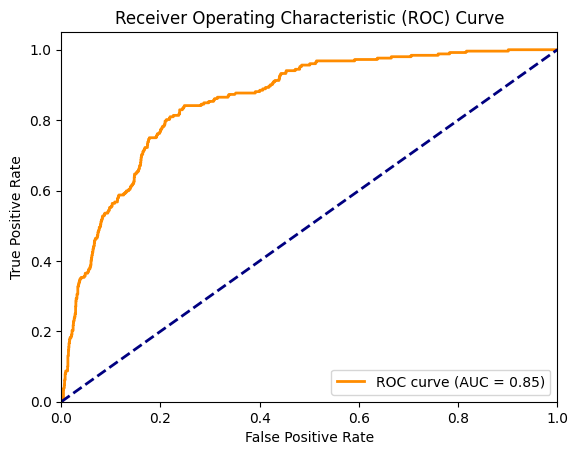

Optimal threshold: 0.9540340304374695
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1802
           1       0.32      0.84      0.46       252

    accuracy                           0.76      2054
   macro avg       0.65      0.79      0.66      2054
weighted avg       0.89      0.76      0.80      2054



In [268]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, results)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold: {optimal_threshold}")

# Use the optimal threshold
y_pred_optimal = (results > optimal_threshold).astype(int)
print(classification_report(Y_test, y_pred_optimal))